In [ ]:
# https://github.com/Kaggle/kaggle-environments/blob/master/kaggle_environments/envs/rps/rps.json
# 

> Описать поведение бота, который будет играть с такими же ботами в игру «камень-ножницы-бумага». Поведение бота описывается с помощью функции, которая принимает на вход информацию о прошлых играх.

> Обозначения для ходов:
> - `0` - камень
> - `1` - бумага
> - `2` - ножницы

### Подготовка окружения

In [3]:
# Подключаем нужные библиотеки
import numpy as np
import pandas as pd
import random
import math

import matplotlib.pyplot as plt
import seaborn as sns

# Функции для создания агентов и их оценивания
from kaggle_environments import make, evaluate

import collections
import warnings

warnings.filterwarnings('ignore')

### Крафтинг агентов
Создаём различных агентов и определяем их стратегии

In [55]:
%%writefile agent_always_rock.py
# 1. Агент, который всегда выбирает "камень"

def agent_always_rock(observation, configuration):
    '''
    Агент, который всегда выбирает 'камень' (0).
    '''
    return 0

Overwriting agent_always_rock.py


In [56]:
%%writefile agent_always_paper.py
# 2. Агент, который всегда выбирает "бумагу"

def agent_always_paper(observation, configuration):
    '''
    Агент, который всегда выбирает 'бумагу' (1).
    '''
    return 1

Overwriting agent_always_paper.py


In [57]:
%%writefile agent_always_scissors.py
# 3. Агент, который всегда выбирает "ножницы"

def agent_always_scissors(observation, configuration):
    '''
    Агент, который всегда выбирает 'ножницы' (2).
    '''
    return 2

Overwriting agent_always_scissors.py


In [58]:
%%writefile agent_rock_paper.py
# 4. Агент, который случайно выбирает между "камнем" и "бумагой"

import random


def agent_rock_paper(observation, configuration):
    '''
    Случайно выбирает между 'камнем' (0) и 'бумагой' (1).
    '''
    return random.randint(0, 1)

Overwriting agent_rock_paper.py


In [59]:
%%writefile agent_paper_scissors.py
# 5. Агент, который случайно выбирает между "бумагой" и "ножницами"

import random


def agent_paper_scissors(observation, configuration):
    '''
    Случайно выбирает между 'бумагой' (1) и 'ножницами' (2).
    '''
    return random.randint(1, 2)

Overwriting agent_paper_scissors.py


In [60]:
%%writefile agent_nash_equilibrium.py
# 6. Агент по принципу равновесия Нэша (случайный выбор)

import random


def agent_nash_equilibrium(observation, configuration):
    '''
    Случайный выбор действия для достижения равновесия Нэша.
    '''
    return random.randint(0, 2)

Overwriting agent_nash_equilibrium.py


In [61]:
%%writefile agent_copy_opponent.py
# 7. Агент, который копирует последний ход оппонента

import random


def agent_copy_opponent(observation, configuration):
    '''
    Копирует последний ход противника. Если ход первый, выбирает случайно.
    '''
    if observation.step == 0:
        return random.randint(0, 2)  # первый ход случайный
    return observation.lastOpponentAction  # копирует предыдущий ход противника

Overwriting agent_copy_opponent.py


In [62]:
%%writefile agent_naive_predict.py
# 8. Агент, наивно предсказывающий ход соперника

import random


def agent_naive_predict(observation, configuration):
    '''
    Наивно предсказывает следующий ход противника.
    '''
    if observation.step == 0:
        return random.randint(0, 2)  # первый ход случайный
    return (observation.lastOpponentAction + 1) % 3  # против хода соперника

Writing agent_naive_predict.py


In [63]:
%%writefile agent_counter.py
# 9. Агент, выбирающий наиболее частый ход противника

import random


def agent_counter(observation, configuration):
    '''
    Выбирает наиболее частый ход противника.
    '''
    if observation.step == 0:
        return random.randint(0, 2)  # первый ход случайный
    opponent_actions = observation['observation']['opponentActions']
    most_common = max(set(opponent_actions), key=opponent_actions.count)
    return (most_common + 1) % 3

Writing agent_counter.py


In [64]:
%%writefile agent_reactionary.py
# 10. Агент, который реагирует на последние действия противника

import random
import math


def get_score(left_move, right_move):
    '''
    Вычисляет результат последнего действия. 
    Возвращает 0 при ничьей, 1 при выигрыше и -1 при проигрыше.
    '''
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

last_react_action = None
def agent_reactionary(observation, configuration):
    '''
    Агент реагирует на последние действия противника.
    Если предыдущий ход был проигран, выбирает новый ход.
    '''
    global last_react_action
    if observation.step == 0:
        last_react_action = random.randrange(0, configuration.signs)  # случайный первый ход
    elif get_score(last_react_action, observation.lastOpponentAction) <= 1:
        last_react_action = (observation.lastOpponentAction + 1) % configuration.signs  # выбирает следующий ход

    return last_react_action

Overwriting agent_reactionary.py


In [65]:
%%writefile agent_counter_reactionary.py
# 11. Агент, который выбирает действие в зависимости от результатов последних ходов

import random
import math

last_counter_action = None
def get_score(left_move, right_move):
    '''
    Возвращает счет на основе разницы между ходами.
    '''
    delta = (
        right_move - left_move
        if (left_move + right_move) % 2 == 0
        else left_move - right_move
    )
    return 0 if delta == 0 else math.copysign(1, delta)

def agent_counter_reactionary(observation, configuration):
    '''
    Если агент выиграл, выбирает действие, чтобы противодействовать.
    Иначе адаптируется к ходу противника.
    '''
    global last_counter_action
    if observation.step == 0:
        last_counter_action = random.randrange(0, configuration.signs)  # случайный первый ход
    elif get_score(last_counter_action, observation.lastOpponentAction) == 1:
        last_counter_action = (last_counter_action + 2) % configuration.signs  # если выиграл, выбирает контр-ход
    else:
        last_counter_action = (observation.lastOpponentAction + 1) % configuration.signs  # выбирает ход противника + 1

    return last_counter_action

Overwriting agent_counter_reactionary.py


In [66]:
%%writefile agent_statistical.py
# 12. Агент, который анализирует статистику ходов противника

import random


action_histogram = {}

def agent_statistical(observation, configuration):
    '''
    Запоминает ходы противника и выбирает действие, чтобы противодействовать
    наиболее частому ходу противника.
    '''
    global action_histogram
    if observation.step == 0:
        action_histogram = {}  # очищает историю в начале
        return random.randint(0, 2)  # случайный ход в начале
    
    action = observation.lastOpponentAction
    action_histogram[action] = action_histogram.get(action, 0) + 1  # считает ходы противника

    mode_action = max(action_histogram, key=action_histogram.get)  # находит наиболее частый ход
    return (mode_action + 1) % configuration.signs  # возвращает контр-ход

Overwriting agent_statistical.py


In [67]:
%%writefile agent_Jonson.py
# 13. Агент Джонсона с анализом паттернов противника

import numpy as np
import collections


def agent_Jonson(observation, configuration):
    '''
    Агент с анализом паттернов противника. Использует таблицу частот для предсказания.
    '''
    k = 2
    global table, action_seq
    if observation.step % 25 == 0:
        action_seq, table = [], collections.defaultdict(lambda: [1, 1, 1])  # обновляет таблицу каждые 25 шагов
    if len(action_seq) <= 2 * k + 1:
        action = int(np.random.randint(3))
        if observation.step > 0:
            action_seq.extend([observation.lastOpponentAction, action])  # добавляет последний ход противника
        else:
            action_seq.append(action)
        return action

    key = ''.join([str(a) for a in action_seq[:-1]])  # ключ на основе последовательности ходов
    table[key][observation.lastOpponentAction] += 1  # обновляет таблицу по ключу

    action_seq[:-2] = action_seq[2:]
    action_seq[-2] = observation.lastOpponentAction
    key = ''.join([str(a) for a in action_seq[:-1]])
    
    if observation.step < 50:
        next_opponent_action_pred = np.argmax(table[key])  # предсказание по таблице
    else:
        scores = np.array(table[key])
        next_opponent_action_pred = np.random.choice(3, p=scores/scores.sum())
        
    action = (next_opponent_action_pred + 1) % 3
    if observation.step > 90:
        action = next_opponent_action_pred
    action_seq[-1] = action
    return int(action)

Overwriting agent_Jonson.py


In [68]:
%%writefile agent_transition.py
# 14. Агент с матрицей переходов для предсказания действий противника

import numpy as np
import pandas as pd
import random


T = np.zeros((3, 3))
P = np.zeros((3, 3))

a1, a2 = None, None

def agent_transition(observation, configuration):
    '''
    Агент анализирует переходы между действиями противника и предсказывает следующее.
    '''
    global T, P, a1, a2
    if observation.step > 1:
        a1 = observation.lastOpponentAction
        T[a2, a1] += 1   # обновление матрицы переходов
        P = np.divide(T, np.maximum(1, T.sum(axis=1)).reshape(-1, 1))
        a2 = a1
        if np.sum(P[a1, :]) == 1:
            return int((np.random.choice([0, 1, 2], p=P[a1, :]) + 1) % 3)  # предсказание на основе вероятностей
        else:
            return int(np.random.randint(3))  # случайный ход
    else:
        if observation.step == 1:
            a2 = observation.lastOpponentAction
        return int(np.random.randint(3))

Overwriting agent_transition.py


### Турнир
Создаем окружение и запускаем турнир между агентами

In [69]:
# Создание игровой среды
env = make('rps', 
           configuration={'episodeSteps': 10},  # количество ходов
           debug=True)

# Запуск игры
env.run(['agent_copy_opponent.py', 'agent_always_paper.py'])

[[{'action': 0,
   'reward': 0,
   'info': {},
   'observation': {'remainingOverageTime': 60, 'step': 0, 'reward': 0},
   'status': 'ACTIVE'},
  {'action': 0,
   'reward': 0,
   'info': {},
   'observation': {'remainingOverageTime': 60, 'reward': 0},
   'status': 'ACTIVE'}],
 [{'action': 1,
   'reward': 0,
   'info': {},
   'observation': {'remainingOverageTime': 60,
    'step': 1,
    'reward': 0,
    'lastOpponentAction': 1},
   'status': 'ACTIVE'},
  {'action': 1,
   'reward': 0,
   'info': {},
   'observation': {'remainingOverageTime': 60,
    'reward': 0,
    'lastOpponentAction': 1},
   'status': 'ACTIVE'}],
 [{'action': 1,
   'reward': 0,
   'info': {},
   'observation': {'remainingOverageTime': 60,
    'step': 2,
    'reward': 0,
    'lastOpponentAction': 1},
   'status': 'ACTIVE'},
  {'action': 1,
   'reward': 0,
   'info': {},
   'observation': {'remainingOverageTime': 60,
    'reward': 0,
    'lastOpponentAction': 1},
   'status': 'ACTIVE'}],
 [{'action': 1,
   'reward': 0,


Воспользуемся функцией evaluate из библиотеки kaggle_environments с помощью которой запустим наших агентов и проведем эксперимент на заданном количестве игр

In [70]:
evaluate(
    'rps',  # environment to use
    ['agent_always_rock.py', 
     'agent_copy_opponent.py'],  # agents to evaluate
    configuration={'episodeSteps': 100}  # number of episodes 
)

[[0, 0]]

In [71]:
evaluate(
    'rps',  # environment to use
    ['agent_always_rock.py', 
     'agent_always_paper.py'],  # agents to evaluate
    configuration={'episodeSteps': 100}  # number of episodes 
)

[[-99.0, 99.0]]

In [28]:
env.reset()
env.run(['agent_always_rock.py', 'agent_copy_opponent.py'])
env.render(mode='ipython', width=500, height=450)

In [44]:
# Создаем окружение для игры с заданным количеством ходов
env = make('rps', configuration={'episodeSteps': 100})

# Здесь загружаем созданных агентов
# (предполагается, что файлы агентов уже созданы, как показано ранее)

# Дополнительные эксперименты: запуск определенных агентов против друг друга

def test_agents(agents: list, steps=1000):
    env.run(agents)
    env.render(mode='ipython', width=500, height=400)
    print(
        f'Результат для {agents}:', 
        evaluate('rps', agents, 
                 configuration={'episodeSteps': steps})
    )

# 1. Запускаем игру между агентом Jonson и агентом rock
test_agents(['agent_Jonson.py', 'agent_always_rock.py'])

# 2. Запускаем игру между агентом copy_opponent и агентом Jonson
test_agents(['agent_copy_opponent.py', 'agent_Jonson.py'])

# 3. Запускаем игру между агентом nash_equilibrium и агентом Jonson
test_agents(['agent_nash_equilibrium.py', 'agent_Jonson.py'])

# 4. Запускаем игру между двумя агентами Jonson
test_agents(['agent_Jonson.py', 'agent_Jonson.py'])

Результат для ['agent_Jonson.py', 'agent_always_rock.py']: [[79.0, -79.0]]


Результат для ['agent_copy_opponent.py', 'agent_Jonson.py']: [[0, 0]]


Результат для ['agent_nash_equilibrium.py', 'agent_Jonson.py']: [[0, 0]]


Результат для ['agent_Jonson.py', 'agent_Jonson.py']: [[0, 0]]


In [ ]:
def run_tournament(agents):
    env = make("rps", configuration={"episodeSteps": 100})
    scores = {agent: 0 for agent in agents}
    
    for i, agent1 in enumerate(agents):
        for agent2 in agents[i + 1:]:
            result = env.run([agent1, agent2])
            final_scores = result[-1][0]['reward'], result[-1][1]['reward']
            scores[agent1] += final_scores[0]
            scores[agent2] += final_scores[1]
    return scores

# agents = [always_rock, always_scissors, always_paper, random_agent, copy_opponent, predict_opponent]
scores = run_tournament(agents)

# Выводим результаты
for agent, score in sorted(scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{agent}: {score} баллов")


In [73]:
# Турнир между агентами
agents = ['always_rock', 'always_paper', 'always_scissors', 'rock_paper', 'paper_scissors', 
          'nash_equilibrium', 'copy_opponent', 'naive_predict',
          'counter', 'reactionary', 'counter_reactionary', 
          'statistical', 'Jonson', 'transition']

# Добавляем 'agent_' и '.py' к каждому агенту
agents_py = [f'agent_{a}.py' for a in agents]
n_agents = len(agents)

# Инициализируем матрицу результатов
scores = np.zeros((n_agents, n_agents))

# Играем каждый агент против каждого
for a1 in range(n_agents):
    for a2 in range(a1 + 1, n_agents):
        # Запускаем один матч на 100 ходов
        result = evaluate('rps', 
                          [agents_py[a1], agents_py[a2]], 
                          configuration={'episodeSteps': 100}, 
                          num_episodes=1)
        scores[a1][a2] = result[0][0]  # сохраняем результат для агента a1
        scores[a2][a1] = result[0][1]  # сохраняем результат для агента a2

# Определяем победителя
vic = []
for a1 in range(n_agents):
    cnt_vic = sum(1 for a2 in range(n_agents) if scores[a1][a2] > 0)  # считаем победы агента
    vic.append(cnt_vic)

# Определяем индексы победителей
i_victors = [i for i, v in enumerate(vic) if v == max(vic)]
if len(i_victors) > 1:
    print('Победитель:', '\n', *[agents_py[i] for i in i_victors], '!')
else:
    print('Победители:', agents_py[i_victors[0]], '!')

Победители: agent_reactionary.py !


In [81]:
# Строим матрицу корреляций
df_scores = pd.DataFrame(scores, index=agents, columns=agents)

df_scores

,always_rock,always_paper,always_scissors,rock_paper,paper_scissors,nash_equilibrium,copy_opponent,naive_predict,counter,reactionary,counter_reactionary,statistical,Jonson,transition
always_rock,0.0,-99.0,99.0,-49.0,0.0,0.0,0.0,-98.0,1.0,-99.0,-50.0,-99.0,-46.0,-98.0
always_paper,99.0,0.0,-99.0,51.0,-53.0,0.0,0.0,-98.0,1.0,-97.0,-48.0,-98.0,-40.0,-98.0
always_scissors,-99.0,99.0,0.0,0.0,46.0,0.0,0.0,-97.0,1.0,-97.0,-50.0,-97.0,-24.0,-97.0
rock_paper,49.0,-51.0,0.0,0.0,-22.0,0.0,0.0,-29.0,1.0,-24.0,0.0,0.0,-20.0,0.0
paper_scissors,0.0,53.0,-46.0,22.0,0.0,0.0,0.0,0.0,1.0,0.0,-20.0,0.0,0.0,-23.0
nash_equilibrium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-22.0,0.0,0.0,0.0,0.0
copy_opponent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-50.0,1.0,-50.0,99.0,-22.0,0.0,0.0
naive_predict,98.0,98.0,97.0,29.0,0.0,0.0,50.0,0.0,1.0,0.0,-97.0,49.0,0.0,0.0
counter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
reactionary,99.0,97.0,97.0,24.0,0.0,22.0,50.0,0.0,1.0,0.0,-97.0,59.0,0.0,0.0


### Анализ результатов

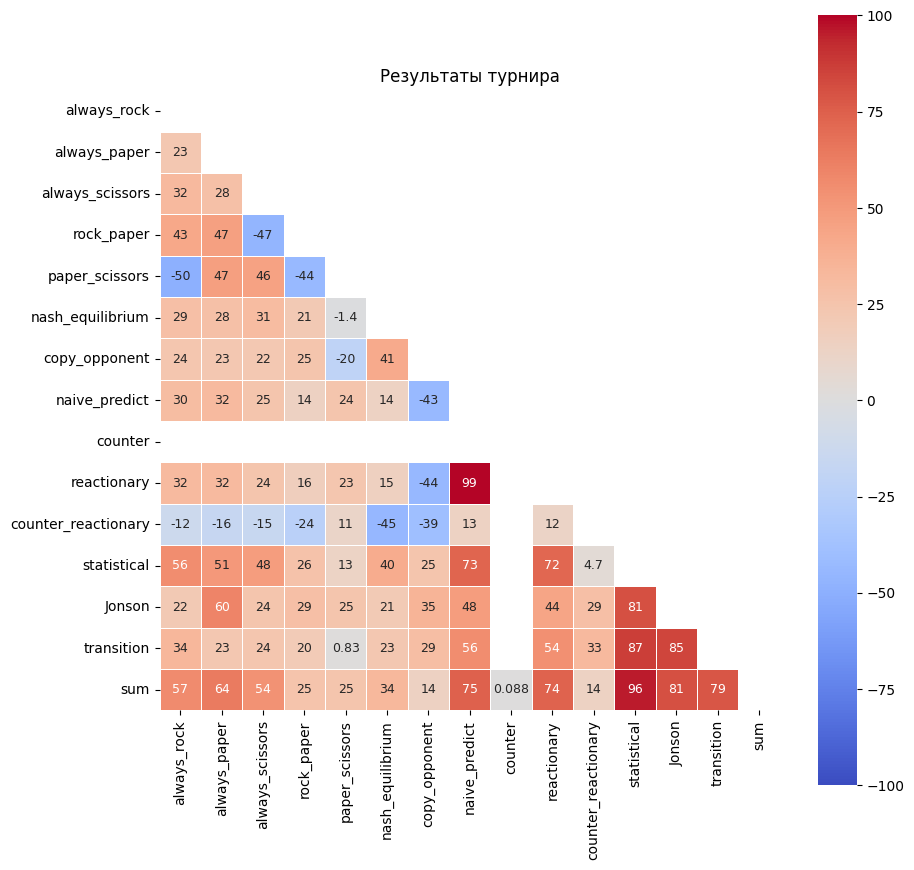

In [80]:
# Строим дополнительную визуализацию
import math
from matplotlib.colors import LinearSegmentedColormap

cmatrix = df_scores.corr() * 100
cmap = LinearSegmentedColormap.from_list('RedGreenRed', 
                                         ['crimson', 'yellow', 'yellowgreen', 'yellow'], 
                                         20)
mask = np.triu(np.ones(cmatrix.shape[0]), k=0)

# Тепловая карта матрицы очков
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    ax=ax, data=cmatrix, 
    cmap='coolwarm',
#     cmap=cmap, 
    vmin=-100, vmax=100, 
    linewidths=.5, 
    square=True, annot=True, 
    mask=mask, 
    annot_kws={'size':35 / math.sqrt(cmatrix.shape[0])})
plt.title('Результаты турнира')
plt.show()

In [84]:
# Выявляем топ-3
df_scores['sum'] = df_scores[agents].sum(axis=1)
df_scores.sort_values(by=['sum'], ascending=False, inplace=True)

# print(f"Победитель: {df_scores['sum'].idxmax()}")
print('Топ-3:')
print(df_scores.head(5)['sum'])

Топ-3:
transition             412.0
reactionary            352.0
naive_predict          325.0
counter_reactionary    187.0
statistical            168.0
Name: sum, dtype: float64


In [76]:
# 1. Подготовка данных для анализа
# Считаем общее количество побед каждого агента
df_scores["Winner"] = df_scores.apply(
    lambda row: row["Agent1"] 
    if row["Score1"] > row["Score2"] else (row["Agent2"] 
                                           if row["Score2"] > row["Score1"] else "Draw"), 
    axis=1
)

# Подсчет побед каждого агента
win_counts = df_results["Winner"].value_counts()

# Удалим ничьи для более корректного анализа победителей
win_counts_no_draw = win_counts[win_counts.index != "Draw"]

KeyError: 'Score1'

In [ ]:
# 2. Визуализация данных
import matplotlib.pyplot as plt
import seaborn as sns

# Гистограмма побед агентов
plt.figure(figsize=(10, 6))
sns.barplot(x=win_counts_no_draw.index, y=win_counts_no_draw.values, palette="viridis")
plt.title("Количество побед каждого агента", fontsize=16)
plt.xlabel("Агенты", fontsize=14)
plt.ylabel("Количество побед", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# 3. Матрица очков между агентами
pivot_table = df_scores.pivot_table(
    index="Agent1", columns="Agent2", values="Score1", aggfunc="sum"
)

# Тепловая карта матрицы очков
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5)
plt.title("Матрица очков между агентами", fontsize=16)
plt.xlabel("Agent2", fontsize=14)
plt.ylabel("Agent1", fontsize=14)
plt.show()

# 4. Выявление топ-3 победителей
top_3_winners = win_counts_no_draw.head(3)
print("Топ-3 победителей турнира:")
print(top_3_winners)

In [49]:
# 5. Запускаем игру между агентами transition и reactionary
test_agents(['agent_transition.py', 'agent_reactionary.py'])

Результат для ['agent_transition.py', 'agent_reactionary.py']: [[0, 0]]
